## Stat 4609 HW 3
***
In this homework assignment, we want to implement random forest for classification from scratch based on the decision tree.


The algorithm of the random forest is shown below.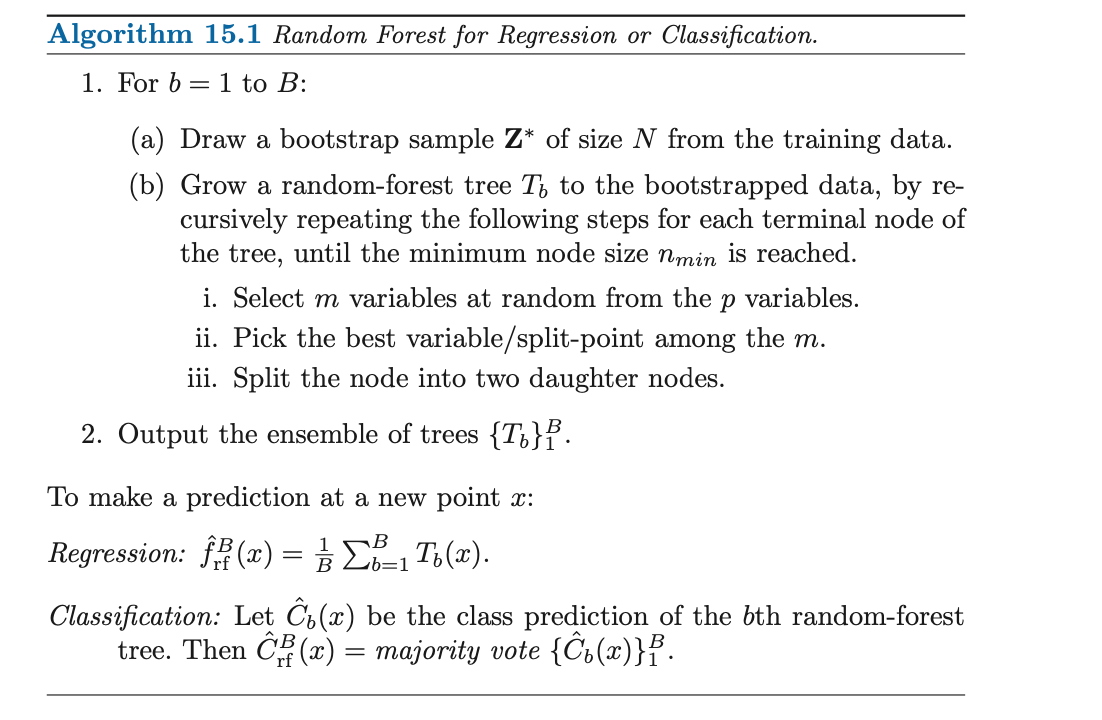)

## This task consists of two parts, a short essay, and programming. 

##  Part I, you need to write a short essay to answer the following questions. 

1. Please compare Decision Tree method, and Random Forest for classification task. If necessary, please include references properly. 

2. Please illustrate how you could implement random forest with the help of python class ```DecisionTree```. *You can write some pseudo code for better illustration.*


[The short essay should be around 500 words. ] 


## Part I Short Essay

1. 
Decision trees partition the feature space to classify observations into different classes.
For categorical variables, we split according to the category value and for continuous variables, we divide according to some threshold value.
For every observation in a specific region/partition, we use the mean of all response values in that partition as the predicted value.

To create the partition, we make the split if the mean square error decreases after we make the split. However, we cannot consider each possible split that can be made, so we use the recursive binary splitting approach, picking the split giving the best reduction in error at that step and not looking forward to choosing a split that gives best results overall. 

Random forest combines several decision trees while making predictions. We build these trees on bootstrapped samples of the data and only consider a random sample of the predictors to use for each tree.

Decision trees are likely to have a lower bias compared to random forest, as it uses all the available features to fit its model. This will lead to it to produce more accurate predictions on the train set. However, the decision tree may not generalise well to the test set data as overfitting of the model may occur due to not having enough controls to reduce the complexity of the model. 

Random forest takes the majority vote of several decision trees, hence reducing the variance of the predicted value. For each tree, we take a subset of the features available to fit the mode. Although this increases the bias of the mode as the features available in fitting the model are restricted, the variance of the model is reduced as the model is a combination of multiple trees. This avoids overfitting and may improve MSE on the test set as compared to using a single decision tree. Taking bootstrapped samples of the data while fitting each tree would ensure that overfitting is avoided. This improves the stability of prediction as small perturbation in the train set data would not change the predicted value as much compared to decision trees. (Ali et al., 2012, Hastie, 2009)

However, decision tree requires far less computing power as we only have to build one decision tree as compared to random forest. It also has better interpretability compared to random forest as there is only one tree to interpret. This may be advantageous as we may need to explain our machine learning models to external parties not familiar with statistical methods. 
 
Ali, J., Khan, R., Ahmad, N., & Maqsood, I. (2012). Random forests and decision trees. International Journal of Computer Science Issues, 9(5), 272–278. http://ijcsi.org/papers/IJCSI-9-5-3-272-278.pdf

Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning. In Springer series in statistics. https://doi.org/10.1007/978-0-387-84858-7


<br>
<br>
2. Implementing the Random Forest

Set B, number of decision trees we want to include in our random forest 
Set D, number of features we want to use to training random forest

For i in B:
1.	create bootstrap sample (sample N observations from data with replacement)
2.	select D features out of all features

Fit model using the bootstrap sample and the D features chosen
While minimum node size, n_min not reached:
1.	From all the D features, we choose the best variable that minimizes the loss function after splitting
(function can be misclassification cost, gini index, entropy)
2.	We then split the node into 2 daughter nodes, with data with the variable value below the splitting threshold value on the left and data with the variable value above the splitting threshold on the right

Obtain the fi(x), prediction of the ith model

After fitting B decision trees, we classify the observation based on the class that gets the majority vote out of the B models





## Part II Implementation of Random forest from scratch. 

### 1. Implement the decision tree


First, you should write a class that implements the decision tree for a classification task. You will need this to fit the Random Forest later.


In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

In [2]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            # note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

def greedy_test(node, cost_fn, n_features=None):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.

    #choose randomly from the subset of features
    if n_features=="log2":
        flr_n_features=int(np.floor(np.log2(num_features)))
    elif n_features=="sqrt":
        flr_n_features=int(np.floor(np.sqrt(num_features)))
    elif type(n_features)==int:
        flr_n_features=n_features

    if n_features!=None:
        bootstrap_features=np.random.choice(a=num_features,size=flr_n_features,replace=False)
    else:
        bootstrap_features=range(num_features)
    
    for f in bootstrap_features:
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1,n_features=None):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        self.n_features = n_features  # Number of features to consider at each node
        
    def fit(self, data, labels ):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels) + 1
        #below are initialization of the root of the decision tree
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn, self.n_features)
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if np.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present node
        node.left = left
        node.right = right
        
    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        for n, x in enumerate(data_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
        return class_probs


In [3]:
# ## Load data
# from sklearn import datasets
# dataset = datasets.load_iris()
# x, y = dataset['data'], dataset['target']
# (num_instances, num_features), num_classes = x.shape, np.max(y)+1
# inds = np.random.permutation(num_instances)
# #train-test split)
# x_train, y_train = x[inds[:100]], y[inds[:100]]
# x_test, y_test = x[inds[100:]], y[inds[100:]]

# dt= DecisionTree(cost_fn=cost_gini_index,n_features="sqrt")
# dt.fit(x_train,y_train)
# dt_predict=dt.predict(x_test)

# #compute accuracy
# correct = 0
# for i in range(len(dt_predict)):
#     if np.argmax(dt_predict[i])==y_test[i]:
#         correct+=1
# accuracy = correct/len(dt_predict)

# print(dt.n_features)

### 2. Let's start work on the implementation of random forest. 
The skeleton of python class ```randomforest``` is provided. Please, implement the two important python methods, ```fit```, and ```predict```. 

Below is the description for the arguements, 

We are creating a random forest regressor, although the same code can be slightly modified to create a classifier. To start out, we need to know what our black box takes as input to yield the output (prediction) so we need to know the parameters that define our random forest :
x: independent variables of training set. To keep things minimal and simple I am not creating a separate fit method hence the base class constructor will accept the training set.

- ```x or y```: the random and corresponding dependent variables necessary for supervised learning (Random forest is a supervised learning technique)
- ```n_trees``` : number of uncorrelated trees we ensemble to create the random forest.
- ```n_features```: the number of features to sample and pass onto each tree, this is where feature bagging happens. It can either be ```"sqrt"```, ```"log2"``` or an integer. In case of sqrt, the number of features sampled to each tree is square root of total features and log base 2 of total features in case of log2.

- ```sample_size```: the number of rows randomly selected and passed onto each tree. This is usually equal to total number of rows but can be reduced to increase performance and decrease correlation of trees in some cases (bagging of trees is a completely separate machine learning technique)
depth: depth of each decision tree. Higher depth means more number of splits which increases the over fitting tendency of each tree but since we are aggregating several uncorrelated trees, over fitting of individual trees hardly bothers the whole forest.
- ```min_leaf```: minimum number of samples required in a node to cause further split. Lower the min_leaf, higher the depth of the tree.

- ``` cost_fn```: objective function for decision tree. 



In [4]:
class RandomForest():
    def __init__(self, depth=10, min_leaf=5, n_trees = 8, n_features='log2', sample_sz = 20, cost_fn =cost_misclassification):
        np.random.seed(12)
        self.depth, self.min_leaf = depth, min_leaf 
        self.n_trees = n_trees 
        self.sample_sz, self.n_features =  sample_sz, n_features
        self.cost_fn = cost_fn 

    def fit(self, x, y):
        #---------- fit training data with the help of function __create_tree__ -----# 
        # --- implete step 1 -------# 
                               
        # #create list to store trees
        trees=[]

        for i in range(self.n_trees):
        
            #create tree
            temp_tree=self.__create_tree__(x,y)
            trees.append(temp_tree)

        trees=np.array(trees)
        
        self.trees=trees
        return self
        
    def __create_tree__(self,x,y):
        #---------- create and return one decision tree ---------------------#
        #---  implete (a) and (b) of step 1 in random forest the algorithm in this python method ---- # 
        # return DecisionTree(...)

        #extract number of rows and features
        all_rows=x.shape[0]
       
        #create tree
        tree=DecisionTree(max_depth=self.depth, min_leaf_instances=self.min_leaf, cost_fn=self.cost_fn,n_features=self.n_features)

        #run bootstrap to obtain bootstrap indices
        bootstrap_indices=np.random.choice(a=all_rows, size=self.sample_sz,replace=True)

        #create bootstrap sample of x and y
        bootstrap_x=x[bootstrap_indices]
        bootstrap_y=y[bootstrap_indices]

        #create tree
        tree.fit(bootstrap_x,bootstrap_y)

        return tree
        
        #change back to y_test
    def predict(self, x):
        #---------- return the predicted probability for test data ----------#
        
        forest_prob=[]
        forest_predict=[]
        for i in range(self.n_trees):
            temp_prob=self.trees[i].predict(x)
            forest_prob.append(temp_prob)
            forest_predict.append(np.argmax(temp_prob, axis=1))
                                                                         
        forest_predict=np.array(forest_predict)
        # print(forest_prob)

        #extract number of classes from first tree
        num_classes=max([self.trees[i].num_classes for i in range(self.n_trees)])
        #aggregate votes across all trees
        votes=[]
        for i in range(x.shape[0]):
            vote=[]
            for j in range(num_classes):
                class_count=np.count_nonzero(forest_predict[:,i]==j)
                vote.append(class_count)
            votes.append(vote)
        votes=np.array(votes)
        #calculate probability of class, using frequency of prediction of each class/n_trees as probability
        votes=votes/self.n_trees
        return votes


### Part 3 Experiments and visualization. 

In this section, you need to use the self-implemented random forest to build classification model for Iris dataset. 

(1) We fit the random forest to the training data and predict on the test data. Please also report the test accuracy. [It should be about or higher than 96%] 

*Please use gini index as the cost function.*


(2) Please visualize the result using scattered plots, with the following elements.
- Only use the first two features as the x and y axis for the 2D visualization. 

- Use different shape to represent training data and testing data.

- Use different color to represent different labels.

- Use different shape to mark correct prediction and misclassificaiton for testing samples. 

- Include a legend for the above symbols. 





In [5]:
## Load data
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'], dataset['target']
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

In [6]:
#----- (1) we fit the tree to the training data and predict on the test data. ---## 
random_forest= RandomForest(depth=10,n_trees=100,cost_fn=cost_gini_index,sample_sz=20)
random_forest.fit(x_train,y_train)
y_prob=random_forest.predict(x_test)

#generate prediction of class
y_pred=np.argmax(y_prob, axis=1)

# #check accuracy against test data
print(y_pred)
print(y_test)
print(y_test[y_pred==y_test].shape[0]/y_test.shape[0])

# print(np.mean(x_train))

# print(random_forest.n_features)

[1 1 0 2 1 2 2 1 0 1 1 0 0 2 1 1 1 2 0 1 2 2 2 1 0 0 0 0 2 1 2 0 0 1 1 2 1
 1 2 2 2 0 2 0 0 2 2 1 0 0]
[1 1 0 2 1 2 2 1 0 1 2 0 0 2 2 1 1 2 0 1 2 2 2 1 0 0 0 0 2 1 2 0 0 1 1 2 1
 1 2 2 2 0 2 0 0 2 2 1 0 0]
0.96


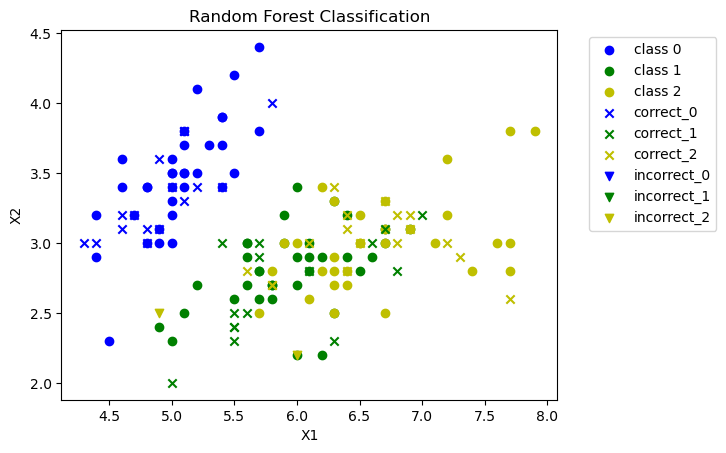

In [7]:
# ----(2) visualization for results ------------------------------------------ 
import matplotlib.pyplot as plt

#title
plt.title("Random Forest Classification")
plt.xlabel("X1")
plt.ylabel("X2")
#training data
#class 0
class_0=x_train[y_train==0]
plt.scatter(class_0[:,0],class_0[:,1],color='b',marker='o',label='class 0')
#class 1
class_1=x_train[y_train==1]
plt.scatter(class_1[:,0],class_1[:,1],color='g',marker='o',label='class 1')
#class 2
class_2=x_train[y_train==2]
plt.scatter(class_2[:,0],class_2[:,1],color='y',marker='o',label="class 2")

#test data
correct_x_test=x_test[y_pred==y_test]
correct_y_test=y_test[y_pred==y_test]
correct_0=correct_x_test[correct_y_test==0]
plt.scatter(correct_0[:,0],correct_0[:,1],color='b',marker='x',label="correct_0")

correct_1=correct_x_test[correct_y_test==1]
plt.scatter(correct_1[:,0],correct_1[:,1],color='g',marker='x',label="correct_1")

correct_2=correct_x_test[correct_y_test==2]
plt.scatter(correct_2[:,0],correct_2[:,1],color='y',marker='x',label="correct_2")

incorrect_x_test=x_test[y_pred!=y_test]
incorrect_y_test=y_test[y_pred!=y_test]
incorrect_0=incorrect_x_test[incorrect_y_test==0]
plt.scatter(incorrect_0[:,0],incorrect_0[:,1],color='b',marker='v',label="incorrect_0")

incorrect_1=incorrect_x_test[incorrect_y_test==1]
plt.scatter(incorrect_1[:,0],incorrect_1[:,1],color='g',marker='v',label="incorrect_1")

incorrect_2=incorrect_x_test[incorrect_y_test==2]
plt.scatter(incorrect_2[:,0],incorrect_2[:,1],color='y',marker='v',label="incorrect_2")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

The intention of this post is to make students and ourselves more familiar with the general working of random forests for it’s better application and debugging in future. Random forests have many more parameters and associated complexities that could not be covered in a single post by me. To study a more robust and wholesome code I suggest you read the sklearn module’s random forest code which is open source. 

